# Olympics EDA
Exploring the input and joined data and cleaning as required

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

plt.style.use('seaborn-whitegrid')
project_path = r'C:\Users\tmais\Documents\Coding\Python\Projects\ML\OlympicsResults'

## Load Olympics results data with features

In [4]:
oly_fname = r'olympics_summer_features.csv'
oly = pd.read_csv(os.path.join(project_path, oly_fname))
oly.head()

,games,country,alpha_3,ioc_code,host,year,gold,silver,bronze,total,...,host_0,host_p4,host_p8,host_p12,games_gold,games_silver,games_bronze,games_medals,n_teams,medals_per_team
0,Athens 1896,Australia,AUS,AUS,0,1896,2,0,0,2,...,0,0,0,0,43,43,36,122,16,7.625
1,Athens 1896,Austria,AUT,AUT,0,1896,2,1,2,5,...,0,0,0,0,43,43,36,122,16,7.625
2,Athens 1896,Bulgaria,BGR,BUL,0,1896,0,0,0,0,...,0,0,0,0,43,43,36,122,16,7.625
3,Athens 1896,Chile,CHL,CHI,0,1896,0,0,0,0,...,0,0,0,0,43,43,36,122,16,7.625
4,Athens 1896,Denmark,DNK,DEN,0,1896,1,2,3,6,...,0,0,0,0,43,43,36,122,16,7.625


### Set target variable and feature sets

In [7]:
target = 'total'

# feature sets
features_full = list(oly.columns[11:])
features = ['pop_40', 'gdppc_12', 'host_0', 'n_teams', 'medals_per_team']
features_pop = features_full[:11]
features_gdppc = features_full[11:15]
features_host = features_full[15:20]
features_mt = features_full[20:]

# combined target and features for simplicity later
tgt_feat = [target]
tgt_feat.extend(features)
features

['pop_40', 'gdppc_12', 'host_0', 'n_teams', 'medals_per_team']

In [8]:
features_mt

['games_gold',
 'games_silver',
 'games_bronze',
 'games_medals',
 'n_teams',
 'medals_per_team']

## Info & visualise nulls

### Data info

In [9]:
oly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2996 entries, 0 to 2995
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   games            2996 non-null   object 
 1   country          2996 non-null   object 
 2   alpha_3          2959 non-null   object 
 3   ioc_code         2996 non-null   object 
 4   host             2996 non-null   int64  
 5   year             2996 non-null   int64  
 6   gold             2996 non-null   int64  
 7   silver           2996 non-null   int64  
 8   bronze           2996 non-null   int64  
 9   total            2996 non-null   int64  
 10  summer           2996 non-null   int64  
 11  pop_0            2339 non-null   float64
 12  pop_4            2500 non-null   float64
 13  pop_8            2492 non-null   float64
 14  pop_12           2482 non-null   float64
 15  pop_16           2463 non-null   float64
 16  pop_20           2440 non-null   float64
 17  pop_24        

### Heatmap of nulls
Aside from a few alpha-3 country codes missing (~1.25%), most missing values are from interpolating the population and GDP per capita data. This was due to missing countries from the data and some data not starting until the mid-1900s.

Note that the population and gdp per capita data only runs to 2018, so Tokyo 2020 cannot use its year's data for predictions.

It is worth considering whether the modelling should be applied only to more recent games anyway where nations have been competing seriously.

<AxesSubplot:ylabel='year'>

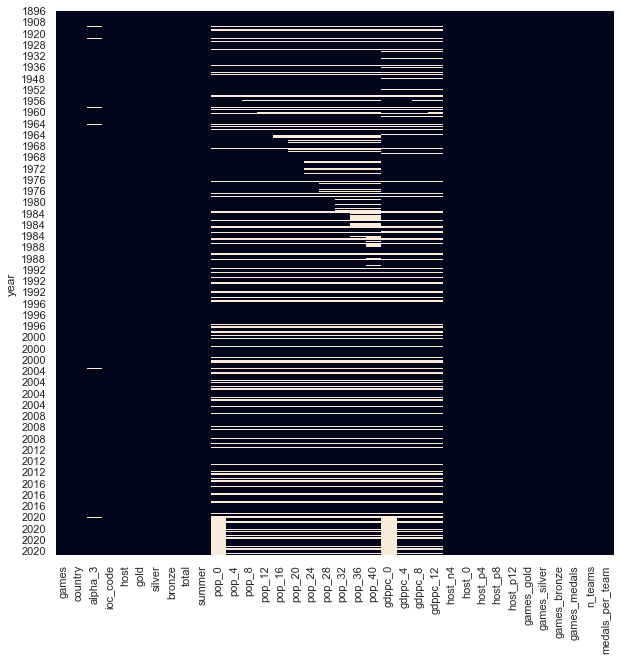

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data=oly.set_index(['year']).isna(), cbar=False)

The patterns in nulls are largely due to missing population or GDP data. Some countries have no data, whereas others the data starts in the mid 90s. The data ends in 2018, meaning that there is no data during Tokyo 2020. Taking values ahead of the games would allow predictions to be made for the Tokyo games (e.g. population data for 4 years before)

## Exploring and Processing the Target Variable

### Hist of target variable

Total number of countries competed over history: 226


Text(0.5, 1.0, "Histogram of Countries' Total Medal Counts for all Olympics")

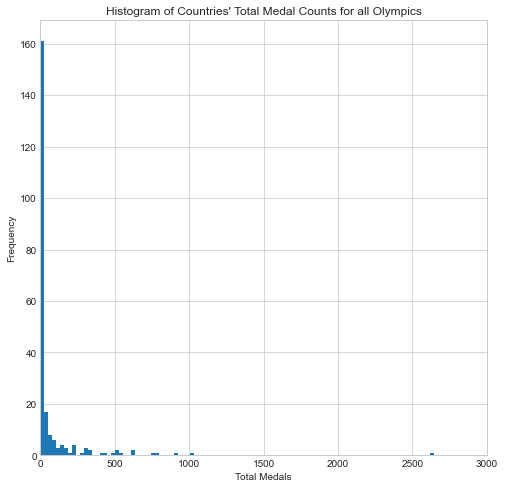

In [26]:
print(f'Total number of countries competed over history: {len(oly.country.unique())}')

fig, ax = plt.subplots(figsize=(8, 8))
oly.groupby('country').sum().total.plot(kind='hist', bins=100, ax=ax)
ax.set_xlim((0, 3000))
ax.set_xlabel('Total Medals')
ax.set_title("Histogram of Countries' Total Medal Counts for all Olympics")

In [56]:
# filter more recent games
subset = oly[oly.year>1980].copy()
# calculate the total medals, and the cumulative sum of medals for countries sorted in descending order by total medals
total = subset.total.sum()
expanding_countries = subset.groupby(['country'])['total'].sum().sort_values(ascending=False).expanding().sum()
# convert to percentages to highlight the share
expanding_countries_perc = expanding_countries / total * 100
# list the top 10 with the cumulative percentages of medals won
expanding_countries_perc.head(10).round(1)

country
United States of America      12.6
People's Republic of China    19.7
Russian Federation            24.5
Germany                       29.2
Great Britain                 33.7
Australia                     37.8
France                        41.6
Japan                         44.9
Italy                         48.2
Republic of Korea             51.2
Name: total, dtype: float64

As expected, medal-wins have been dominated by a small number of countries over the history of the Olympics.

Looking at the percentage of medals won cumulatively by the top winners demonstrates this. Since 1980, 12.6% of medals have been won by the USA. Over a third have been won by the top 5 nations: USA, China, Russia, Germany and Great Britain.

In [59]:
no_medals = oly[oly.total==0].groupby('country').total.count().sort_values(ascending=False)
no_medals.head(10)

country
Luxembourg       20
Monaco           20
Myanmar          18
Liechtenstein    18
Bermuda          17
Malta            17
Chile            17
Guyana           17
Iceland          17
Sri Lanka        16
Name: total, dtype: int64

Above are the countries who've attended the most games without ever winning a medal. Luxembourg and Monaco have each attended 20 games each without ever winning a medal.

### Log of values and other target variable transforms
- **Log:** There are many zero-medal rows so the log transform will be Total + 1

Text(0.5, 1.0, "Histogram of Countries' Logged-Total Medal Counts for all Olympics")

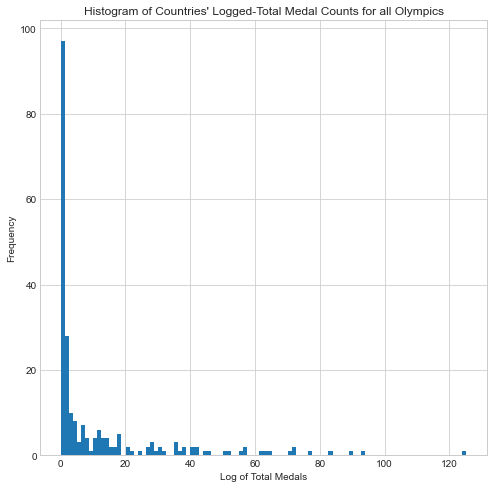

In [62]:
oly['total_log'] = np.log(oly.total + 1)

fig, ax = plt.subplots(figsize=(8, 8))
oly.groupby('country').sum().total_log.plot(kind='hist', bins=100, ax=ax)
# ax.set_xlim((0, 3000))
ax.set_xlabel('Log of Total Medals')
ax.set_title("Histogram of Countries' Logged-Total Medal Counts for all Olympics")

## Correlations

### Features pinned to year of games

In [39]:
t_f = [target]
t_f.extend(features)
oly[t_f].corr()[target].sort_values(ascending=False)

total              1.000000
host_0             0.387033
pop_0              0.297212
gdppc_0            0.223730
medals_per_team    0.135919
n_teams           -0.098022
Name: total, dtype: float64

Being the host nation is the strongest correlate, followed by population and GDP per capita. Medals per team is a weak correlate.

### Population features

In [40]:
t_f = [target]
t_f.extend(features_pop)
oly[t_f].corr()[target].sort_values(ascending=False)

total     1.000000
pop_40    0.353271
pop_36    0.351725
pop_32    0.348622
pop_28    0.345038
pop_24    0.341295
pop_20    0.337068
pop_16    0.331247
pop_12    0.325112
pop_8     0.318711
pop_4     0.312068
pop_0     0.297212
Name: total, dtype: float64

Perhaps surprisingly, population is a stronger predictor the longer before the games one extends.

TODO: produce population features that go further into the past to see if the correlation plateaus/drops again.

### GDP per capita features

In [41]:
t_f = [target]
t_f.extend(features_gdppc)
oly[t_f].corr()[target].sort_values(ascending=False)

total       1.000000
gdppc_12    0.249014
gdppc_8     0.236947
gdppc_4     0.229168
gdppc_0     0.223730
Name: total, dtype: float64

Similarly, GDP per capita is a stronger predictor the longer before the games one extends. This could be because countries with more historic wealth will have more mature sporting institutions and generational national expertise.

TODO: produce gdppc features that go further into the past to see if the correlation plateaus/drops again.

### Hosting features

In [42]:
t_f = [target]
t_f.extend(features_host)
oly[t_f].corr()[target].sort_values(ascending=False)

total       1.000000
host_0      0.387033
host_p8     0.182156
host_p4     0.156028
host_n4     0.154140
host_p12    0.136207
Name: total, dtype: float64

Perhaps unsurprisingly, teams perform best when hosting (strongest predictor). They get more competitor places, have a home-fan advantage, and likely have higher investment in sport in the run-up.

### Visualising correlations with pairplot

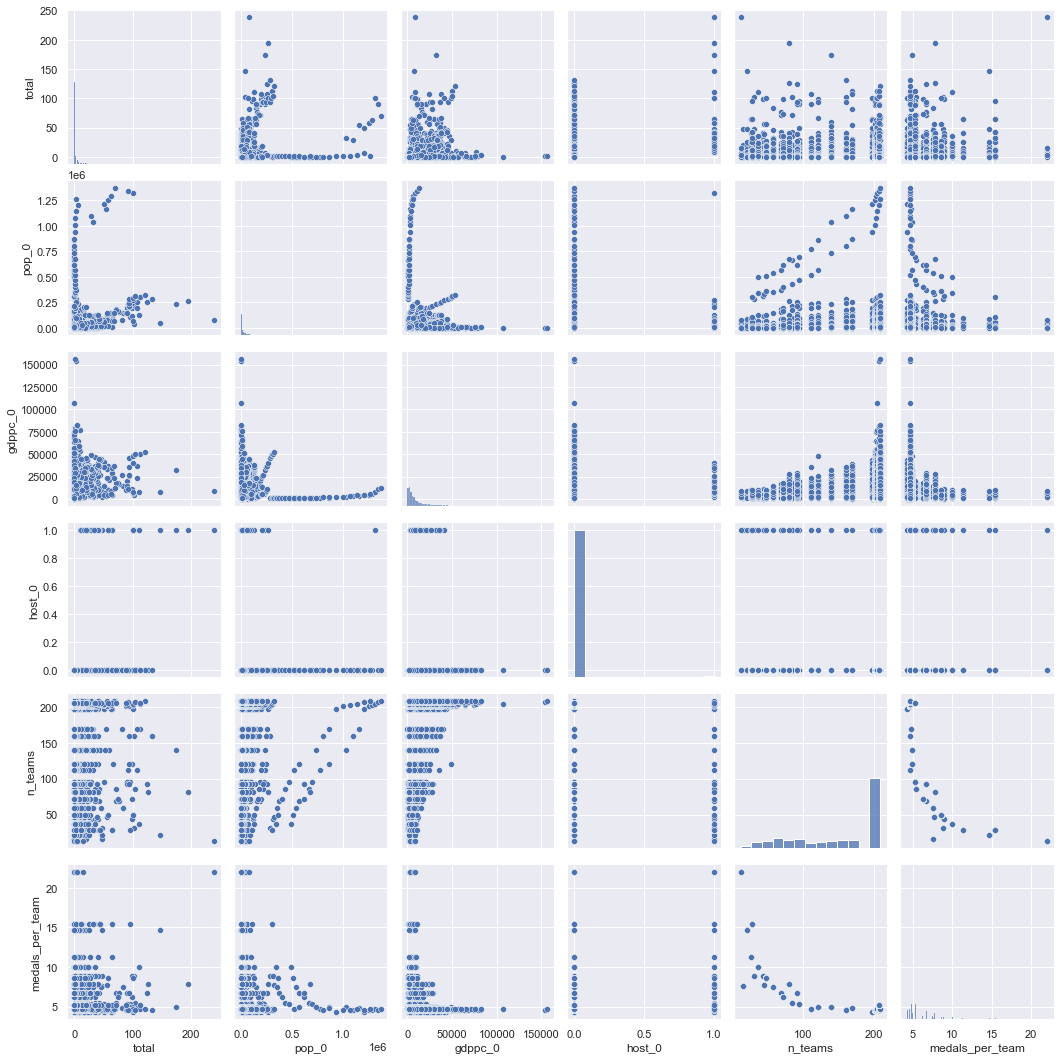

In [44]:
sns.pairplot(data=oly[tgt_feat])

In [117]:
oly.loc[oly.alpha_3=='CHN', ['games', 'alpha_3', 'total', 'pop_0', 'gdppc_0']]

,games,alpha_3,total,pop_0,gdppc_0
225,Los Angeles 1932,CHN,0,496307.0,1039.00
267,Berlin 1936,CHN,0,507959.0,1065.00
314,London 1948,CHN,0,541085.0,833.00
374,Helsinki 1952,CHN,0,568910.0,1047.00
444,Melbourne 1956,CHN,0,621465.0,1189.00
511,Rome 1960,CHN,0,667070.0,1057.00
599,Tokyo 1964,CHN,0,698355.0,1152.00
694,Mexico City 1968,CHN,0,774510.0,1178.00
809,Munich 1972,CHN,0,862030.0,1431.00
1102,Los Angeles 1984,CHN,32,1036825.0,2444.00


C:\Users\tmais\AppData\Local\Temp/ipykernel_11664/3646445193.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  a = ax.set_xticklabels(oly.games.unique(), rotation=45, ha='right')
C:\Users\tmais\AppData\Local\Temp/ipykernel_11664/3646445193.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  a = ax.set_xticklabels(oly.games.unique(), rotation=45, ha='right')
C:\Users\tmais\AppData\Local\Temp/ipykernel_11664/3646445193.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  a = ax.set_xticklabels(oly.games.unique(), rotation=45, ha='right')


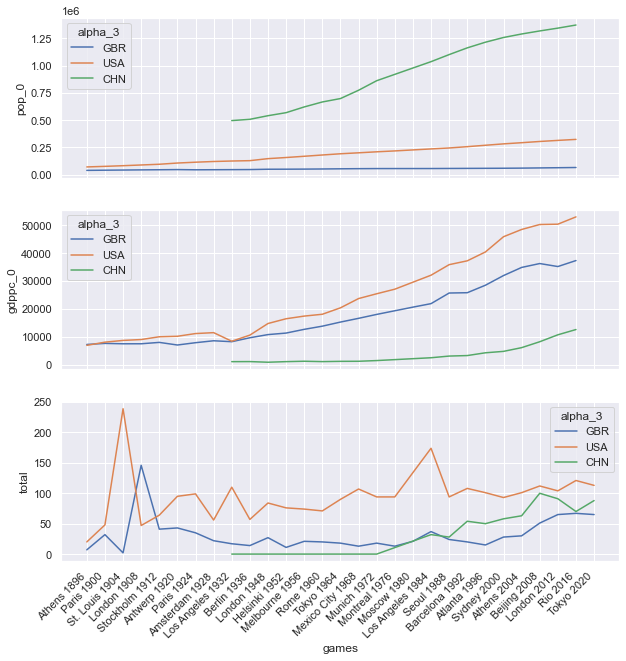

In [143]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
ys = ['pop_0', 'gdppc_0', 'total']
a3s = ['USA', 'CHN', 'GBR']
for i, ax in enumerate(axs):
    sns.lineplot(data=oly[oly.alpha_3.isin(a3s)], x='games', y=ys[i], ax=ax, hue='alpha_3')
    a = ax.set_xticklabels(oly.games.unique(), rotation=45, ha='right')

<AxesSubplot:ylabel='year'>

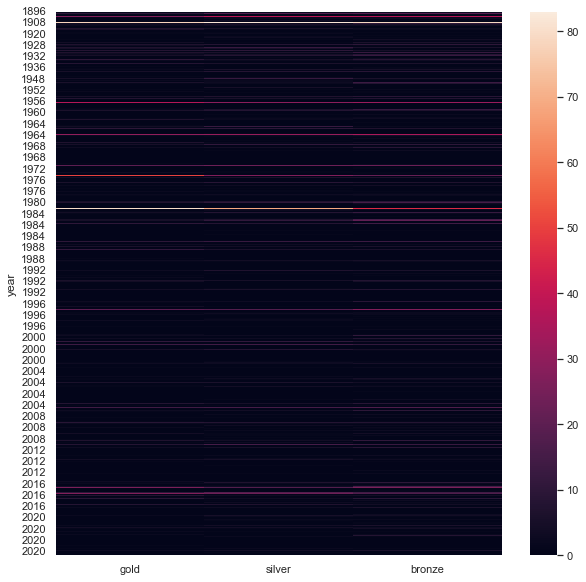

In [144]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data=oly.set_index(['year']).loc[:,['gold', 'silver', 'bronze']])

In [99]:
games = oly.groupby('games')[['summer', 'year']].first().reset_index()
games = games.merge(oly.groupby('games').sum()[['gold', 'silver', 'bronze', 'total']].reset_index(),
                    how='left',
                    left_on='games',
                    right_on='games')
games = games.merge(oly.groupby('games').count()['country'].reset_index(),
                    how='left',
                    left_on='games',
                    right_on='games').sort_values('year')
games.rename(columns={'country': 'n_teams'}, inplace=True)
games['medals_per_team'] = games.total / games.n_teams
games.head()

,games,summer,year,gold,silver,bronze,total,n_teams,medals_per_team
2,Athens 1896,1,1896,43,43,36,122,13,9.384615
19,Paris 1900,1,1900,95,95,93,283,25,11.320000
24,St. Louis 1904,1,1904,97,95,93,285,12,23.750000
9,London 1908,1,1908,110,107,107,324,22,14.727273
25,Stockholm 1912,1,1912,108,105,104,317,28,11.321429


## Population Data

In [7]:
pop_fname = r'population_transformed.csv'
population = pd.read_csv(os.path.join(project_path, pop_fname))
population.head()

,year,country,population
0,1820,Afghanistan,3280.0
1,1870,Afghanistan,4207.0
2,1913,Afghanistan,5730.0
3,1950,Afghanistan,8150.0
4,1951,Afghanistan,8284.0


<AxesSubplot:xlabel='year', ylabel='population'>

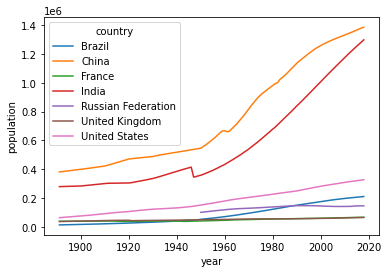

In [13]:
countries = ['France', 'United Kingdom', 'United States', 'China', 'Russian Federation', 'India', 'Brazil']
df = population[population.country.isin(countries) & (population.year>1890)]
sns.lineplot(data=df, x='year', y='population', hue='country')

## Medals per games
Summary
- It seems that the number of medals have grown over the years to mirror the increase in participant teams.

C:\Users\tmais\AppData\Local\Temp/ipykernel_11664/454790422.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  a = ax.set_xticklabels(df.games.unique(), rotation=45, ha='right')


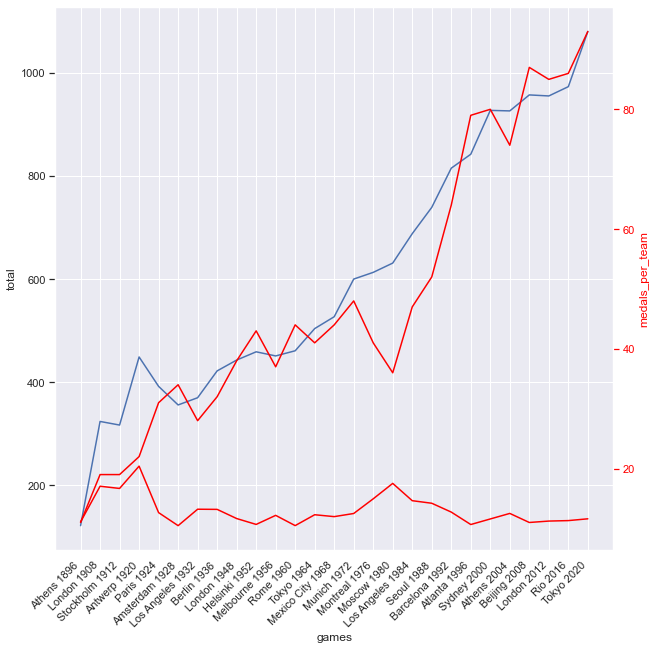

In [84]:
df = games[games.summer==1]
fig, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(data=df, x='games', y='total', ax=ax)
ax2 = plt.twinx()
sns.lineplot(data=df, x='games', y='medals_per_team', ax=ax2, color='red')
sns.lineplot(data=df, x='games', y='n_teams', ax=ax2, color='red')
ax2.grid(b=False)
a = ax.set_xticklabels(df.games.unique(), rotation=45, ha='right')
a = ax2.tick_params(colors='red')
ax2.yaxis.label.set_color('red')

## Medals per country

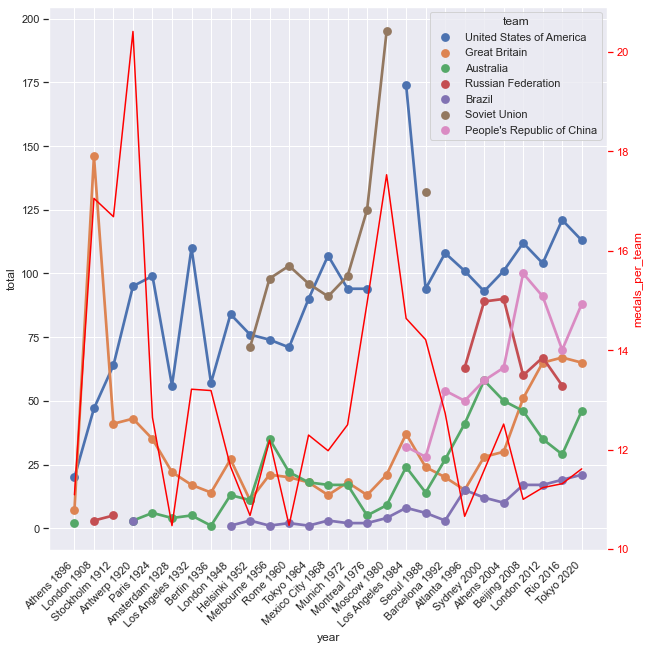

In [88]:
countries = ['Soviet Union', 'Great Britain', 'United States of America', "People's Republic of China", 'Russian Federation', 'Australia', 'Brazil']
df = summer[summer.team.isin(countries) & (summer.year>1890)]
fig, ax = plt.subplots(figsize=(10, 10))
with sns.axes_style('darkgrid'):
    sns.pointplot(data=df, x='year', y='total', hue='team', ax=ax)
    ax.grid(b=True, which='major', color='w', linewidth=1.0)
    a = ax.set_xticklabels(df.games.unique(), rotation=45, ha='right')
    ax2 = plt.twinx()
    sns.lineplot(data=games[games.summer==1], x='games', y='medals_per_team', ax=ax2, color='red')
    ax2.grid(b=False)
    a = ax2.tick_params(colors='red')
    ax2.yaxis.label.set_color('red')

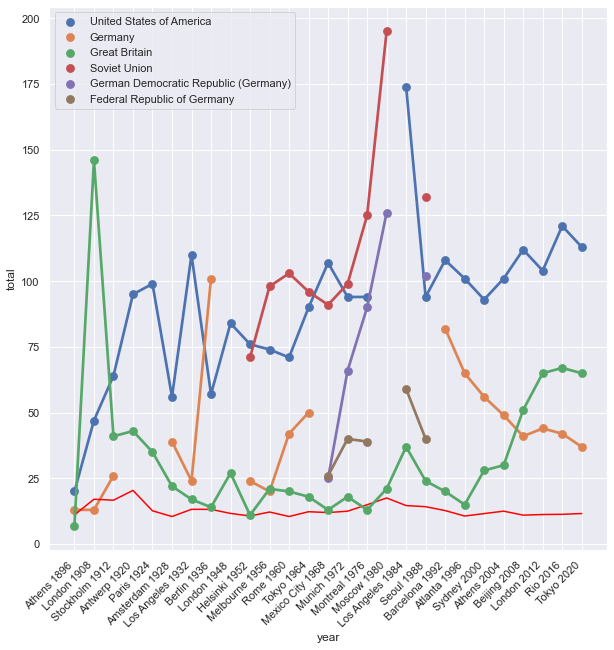

In [96]:
countries = ['Federal Republic of Germany', "German Democratic Republic (Germany)", 'Germany', 'Soviet Union', 'Great Britain', 'United States of America']
df = summer[summer.team.isin(countries) & (summer.year>1890)]
fig, ax = plt.subplots(figsize=(10, 10))
with sns.axes_style('darkgrid'):
    sns.pointplot(data=df, x='year', y='total', hue='team', ax=ax)
    ax.grid(b=True, which='major', color='w', linewidth=1.0)
    a = ax.set_xticklabels(df.games.unique(), rotation=45, ha='right')
    # ax2 = plt.twinx()
    sns.lineplot(data=games[games.summer==1], x='games', y='medals_per_team', ax=ax, color='red')
    # ax2.grid(b=False)
    # a = ax2.tick_params(colors='red')
    # ax2.yaxis.label.set_color('red')